## **Import Libraries**

In [80]:
# Import core libraries for deep learning and scientific computing, neural network building blocks
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F #Functional Utilities
import torch.optim as optim  #For Optimizer

# Import libraries for data manipulation and analysis
import pandas as pd
import csv

# Import libraries for progress monitoring and visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Import libraries for logging and experimentation tracking
import wandb  

# Import libraries for utility functions
import random  
import heapq  



## **SET DEVICE (CPU / GPU)**

In [2]:
# This function determines the appropriate device ("cpu" or "cuda") to use for training.
def set_device():
    """Sets the training device to either "cpu" or "cuda" based on availability.

    Returns:
        str: The chosen device ("cpu" or "cuda").
    """
    device = "cpu"  # Default device is CPU

    # Check if a CUDA GPU is available
    if torch.cuda.is_available():
        device = "cuda"  # Use GPU if available for faster training

    return device  # Return the chosen device

# Call the function to determine the training device
device = set_device()

# Print the chosen device ("cpu" or "cuda")
print(device)


cuda


In [3]:
!wandb login 57566fbb0e091de2e298a4320d872f9a2b200d12

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **LOAD DATA**

In [4]:
def load_data(lang='hin'):
    """
    Loads training, validation, and test data from CSV files.

    Args:
        lang (str, optional): Language code (default: 'hin'). Defaults to 'hin'.

    Returns:
        dict: A dictionary containing the loaded data and maximum sequence lengths.
    """

    # Define base paths based on language
#     base_path = f'D:/DL_A3/Dataset/{lang}'    
    base_path = f'/kaggle/input/vocabs/Dataset/{lang}'

    train_path, val_path, test_path = f'{base_path}/hin_train.csv', f'{base_path}/hin_valid.csv', f'{base_path}/hin_test.csv'

    # Load data using a single loop with list comprehension
    data_lists = []
    for path in [train_path, val_path, test_path]:
        with open(path, 'r', encoding='utf-8') as file:
            reader = csv.reader(file) #read csv file
            data_lists.append([[f"{row[0]}$", f"#{row[1]}$"] for row in reader]) 
      
    data_set = []
    for i in range(0, 6):
        data_set.append([list_item[i%2] for list_item in data_lists[i//2]])
    
    train_x, train_y, val_x, val_y, test_x, test_y = data_set[0], data_set[1], data_set[2], data_set[3], data_set[4], data_set[5]


  # Convert data to NumPy arrays
    train_x, train_y = np.array(train_x), np.array(train_y)
    val_x, val_y = np.array(val_x), np.array(val_y)
    test_x, test_y = np.array(test_x), np.array(test_y)

    # Find maximum sequence lengths (combined for efficiency)
    max_decoder_length = max(len(s) for s in np.concatenate((train_y, val_y, test_y)))
    max_encoder_length = max(len(s) for s in np.concatenate((train_x, val_x, test_x)))

    # Return data as a dictionary
    return {
        "train_x": train_x,
        "train_y": train_y,
        "val_x": val_x,
        "val_y": val_y,
        "test_x": test_x,
        "test_y": test_y,
        "max_decoder_length": max_decoder_length,
        "max_encoder_length": max_encoder_length
    }


## **Corpus**

In [5]:
def create_corpus(dictionary : dict):
    """
    Creates vocabulary dictionaries for input and output sequences.

    Args:
        dict : A dictionary containing train_y, val_y, test_y
    Returns:
        dict: A dictionary containing vocabulary information.
    """
    train_y = dictionary["train_y"]
    val_y = dictionary["val_y"]
    test_y = dictionary["test_y"]

    # Define English vocabulary
    english_vocab = "#$abcdefghijklmnopqrstuvwxyz"

    # Combine target sequences from all datasets to create a complete vocabulary
    all_chars = set.union((set(char for word in train_y for char in word)),
                            set(char for word in val_y for char in word),
                            set(char for word in test_y for char in word))
    all_chars.add('')
    all_chars = sorted(all_chars)

    # Create input vocabulary dictionary (includes the empty string)
    input_corpus_dict = {char: idx+1 for idx, char in enumerate(english_vocab)}
    input_corpus_dict[''] = 0
    input_corpus_length = len(input_corpus_dict)
    

    # Create output vocabulary dictionary (includes the empty string)
    output_corpus_dict = {char: idx for idx, char in enumerate(all_chars)}
    output_corpus_length = len(output_corpus_dict)

    # Create dictionaries for reversed lookups (character -> index)
    reversed_input_corpus = {v: k for k, v in input_corpus_dict.items()}
    reversed_output_corpus = {v: k for k, v in output_corpus_dict.items()}

    # Return a dictionary containing all vocabulary information
    return {
        "input_corpus_length": input_corpus_length,
        "output_corpus_length": output_corpus_length,
        "input_corpus_dict": input_corpus_dict,
        "output_corpus_dict": output_corpus_dict,
        "reversed_input_corpus": reversed_input_corpus,
        "reversed_output_corpus": reversed_output_corpus
    }


## **Word To Tensor**

In [6]:
def create_tensor(data_dict, corpus_dict):
    """
    Creates PyTorch tensors for training and validation data.

    Args:
        data_dict (dict) : Dictionary contaning datasets
        corpus_dict (dict): Dictionary containing vocabulary information.

    Returns:
        dict: A dictionary containing PyTorch tensors for training and validation.
    """

    # Get maximum sequence length
    max_len = max(data_dict["max_encoder_length"], data_dict["max_decoder_length"])

    # Function to convert sequences to tensors with padding
    def create_padded_tensor(sequences, vocab_dict, max_len):
        tensor = np.zeros((max_len, len(sequences)), dtype='int64')
        for i, seq in enumerate(sequences):
            for j, char in enumerate(seq):
                tensor[j, i] = vocab_dict.get(char, 0)  # Use default of 0 for missing characters
        return torch.tensor(tensor)

    # Create tensors for training data
    train_input = create_padded_tensor(data_dict["train_x"], corpus_dict["input_corpus_dict"], max_len)
    train_output = create_padded_tensor(data_dict["train_y"], corpus_dict["output_corpus_dict"], max_len)

    # Create tensors for validation data
    val_input = create_padded_tensor(data_dict["val_x"], corpus_dict["input_corpus_dict"], max_len)
    val_output = create_padded_tensor(data_dict["val_y"], corpus_dict["output_corpus_dict"], max_len)

    # Create tensors for testing data
    test_input = create_padded_tensor(data_dict["test_x"], corpus_dict["input_corpus_dict"], max_len)
    test_output = create_padded_tensor(data_dict["test_y"], corpus_dict["output_corpus_dict"], max_len)

    # Return dictionary containing tensors
    return {
        "train_input": train_input,
        "train_output": train_output,
        "val_input": val_input,
        "val_output": val_output,
        "test_input" : test_input,
        "test_output" : test_output
    }


## **Data Formating & Preprocessing**

In [7]:
def preprocess_data(lang : str):
    dictionary1 = load_data(lang)
    dictionary2 = create_corpus(dictionary1)
    dictionary3 = create_tensor(dictionary1, dictionary2) 
    dictionary4 = {
        "train_input": dictionary3["train_input"],
        "train_output": dictionary3["train_output"],
        "val_input": dictionary3["val_input"],
        "val_output": dictionary3["val_output"],
        "test_input" : dictionary3["test_input"],
        "test_output" : dictionary3["test_output"],
        "input_corpus_length" : dictionary2["input_corpus_length"],
        "output_corpus_length" : dictionary2["output_corpus_length"],
        "input_corpus_dict" : dictionary2["input_corpus_dict"],
        "output_corpus_dict" : dictionary2["output_corpus_dict"],
        "reversed_input_corpus" : dictionary2["reversed_input_corpus"],
        "reversed_output_corpus" : dictionary2["reversed_output_corpus"],
        "train_x" : dictionary1["train_x"],
        "train_y" : dictionary1["train_y"],
        "val_x" : dictionary1["val_x"],
        "val_y" : dictionary1["val_y"],
        "test_x" : dictionary1["test_x"],
        "test_y" : dictionary1["test_y"],
        "max_decoder_length" : dictionary1["max_decoder_length"],
        "max_encoder_length" : dictionary1["max_encoder_length"]
    }   

    return dictionary4


## **Attention Class**

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
    
    def dot_score(self, hidden_state, encoder_state):
        """
        Calculate dot product attention scores.
        Args:
            hidden_state (Tensor): The hidden state of the decoder. Shape: (batch_size, 1, hidden_size)
            encoder_state (Tensor): The output of the encoder. Shape: (batch_size, max_length, hidden_size)
        Returns:
            scores (Tensor): Attention scores. Shape: (batch_size, 1, max_length)
        """
        # Compute dot product between decoder hidden state and encoder output
        scores = torch.sum(hidden_state * encoder_state, dim=2)
        return scores

    def forward(self, hidden, encoder_output):
        """
        Forward pass of the attention mechanism.
        Args:
            hidden (Tensor): The hidden state of the decoder. Shape: (batch_size, 1, hidden_size)
            encoder_output (Tensor): The output of the encoder. Shape: (batch_size, max_length, hidden_size)
        Returns:
            attention_weights (Tensor): Attention weights over encoder outputs. Shape: (batch_size, 1, max_length)
        """
        # Calculate attention scores using dot product
        scores = self.dot_score(hidden, encoder_output)
        
        # Transpose the scores for softmax computation
        scores = scores.t()
        
        # Apply softmax to get attention weights and add an extra dimension for compatibility
        attention_weights = F.softmax(scores, dim=1).unsqueeze(1)
        
        return attention_weights

## **Encoder Class**

In [9]:
class Encoder(nn.Module):

    def __init__(self, PARAM):
        super(Encoder, self).__init__()
        self.input_size = PARAM["encoder_input_size"]
        self.embedding_size = PARAM["embedding_size"]
        self.hidden_size = PARAM["hidden_size"]
        self.num_layers = PARAM["num_layers"]
        self.drop_prob = PARAM["drop_prob"]
        self.cell_type = PARAM["cell_type"]
        self.bidirectional = PARAM["bidirectional"]

        self.dropout = nn.Dropout(self.drop_prob)
        self.embedding = nn.Embedding(self.input_size, self.embedding_size)

        cell_map = {
        "LSTM": nn.LSTM,
        "GRU": nn.GRU,
        "RNN": nn.RNN
        }
        self.cell = cell_map[self.cell_type](
            self.embedding_size, self.hidden_size, self.num_layers,
            dropout=self.drop_prob, bidirectional=self.bidirectional
        )
    
    def forward(self, x):
        embedding = self.embedding(x)
        drops = self.dropout(embedding)
        if self.cell_type == "RNN" or self.cell_type == "GRU":
            encoder_states, hidden = self.cell(drops)
            if self.bidirectional == True:
                encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, :, self.hidden_size:]
            return encoder_states, hidden
        elif self.cell_type == "LSTM":
            encoder_states, (hidden, cell) = self.cell(drops)
            if self.bidirectional == True:
                encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, :, self.hidden_size:]
            return encoder_states, hidden, cell
        
        

## **Decoder Class**

In [10]:
class Decoder(nn.Module):
  def __init__(self, params):
    super(Decoder, self).__init__()

    # Initialize decoder parameters
    self.input_size = params["decoder_input_size"]
    self.embedding_size = params["embedding_size"]
    self.hidden_size = params["hidden_size"]
    self.output_size = params["decoder_output_size"]
    self.num_layers = params["num_layers"]
    self.drop_prob = params["drop_prob"]
    self.cell_type = params["cell_type"]
    self.bidirectional = params["bidirectional"]

    # Dropout layer
    self.dropout = nn.Dropout(self.drop_prob)

    # Embedding layer
    self.embedding = nn.Embedding(self.input_size, self.embedding_size)

    # Linear layer for combining context and decoder output
    self.concatlayer = nn.Linear(self.hidden_size * 2, self.hidden_size)

    # Final output layer
    self.fc = nn.Linear(self.hidden_size, self.output_size)

    # Apply LogSoftmax for probability distribution
    self.log_softmax = nn.LogSoftmax(dim=1)

    # Attention layer
    self.attn = Attention(self.num_layers)

    # Select appropriate RNN cell based on cell_type parameter
    self.cell_map = {
            "LSTM": nn.LSTM,
            "GRU": nn.GRU,
            "RNN": nn.RNN
        }
    self.cell = self.cell_map[self.cell_type](
            self.embedding_size, self.hidden_size, self.num_layers,
            dropout=self.drop_prob
        )

  def forward(self, x, encoder_states, hidden, cell):
    # Embed input word
    x = x.unsqueeze(0)
    embedding = self.embedding(x)
    drops = self.dropout(embedding)

    # Pass through RNN cell based on type
    if self.cell_type == "RNN" or self.cell_type == "GRU":
          outputs, (hidden) = self.cell(drops, hidden)
    elif self.cell_type == "LSTM":
          outputs, (hidden, cell) = self.cell(drops, (hidden, cell))
    else:
          raise ValueError("Invalid cell type during forward pass: {}".format(self.cell_type))

    # Attention mechanism
    attention_weights = self.attn(outputs, encoder_states)
    context = attention_weights.bmm(encoder_states.transpose(0, 1))

    # Squeeze outputs and context
    outputs = outputs.squeeze(0)
    context = context.squeeze(1)

    # Concatenate decoder output and context
    concat_input = torch.cat((outputs, context), 1)

    # Apply activation and linear layer
    concat_output = torch.tanh(self.concatlayer(concat_input))
    predictions = self.log_softmax(self.fc(concat_output))

    # Return predictions, hidden state (and cell for LSTM) and attention weights
    if self.cell_type == "LSTM":
          return predictions, hidden, cell, attention_weights.squeeze(1)
    else:
          return predictions, hidden, attention_weights.squeeze(1)


In [11]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, params, processed_data):
    super(Seq2Seq, self).__init__()
    self.cell_type = params["cell_type"]
    self.encoder = encoder
    self.decoder = decoder
    self.teacher_forcing_ratio = params["tfr"]

  def forward(self, src, target):
    batch_size = src.shape[1]
    target_len = target.shape[0]
    x = target[0, :]
    target_vocab_size = processed_data["output_corpus_length"]
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    
    
    
    # Get encoder output and hidden state (or cell for LSTM)
    if self.cell_type == "LSTM":
        encoder_output, hidden, cell = self.encoder(src)
        cell = cell[:self.decoder.num_layers]
    else:
        encoder_output, hidden = self.encoder(src)
    hidden = hidden[:self.decoder.num_layers]
    
    # Iterate through target sequence
    for i in range(1, target_len):
      # Decode using previous word or teacher forcing
      if self.cell_type == "LSTM":
        output, hidden, cell, _ = self.decoder(x, encoder_output, hidden, cell)
      else:
        output, hidden, _ = self.decoder(x, encoder_output, hidden, None)

      outputs[i] = output

      # Use teacher forcing with a probability
      if random.random() < self.teacher_forcing_ratio:
        next_word = target[i]
      else:
        next_word = output.argmax(dim=1)

      # Update input word for next iteration
      x = next_word

    return outputs

 

## **Setting Optimizer**

In [12]:
def set_optimizer(name, model, learning_rate):
    """
    Creates an optimizer object based on the specified name and learning rate.
    Args:
        name (str): Name of the optimizer (e.g., "adam", "sgd", "rmsprop", "adagrad").
        model (nn.Module): The PyTorch model to be optimized.
        learning_rate (float): The learning rate to use for training.
    Returns:
        torch.optim.Optimizer: The created optimizer object.
    """

    # Define the optimizer based on the provided name
    optimizer = None
    if name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif name == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif name == "adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        # Raise an error if the optimizer name is invalid
        raise ValueError(f"Invalid optimizer name: {name}")

    # Ensure an optimizer was created
    if optimizer is None:
        raise ValueError("Failed to create optimizer. Please check the provided name.")

    return optimizer


In [24]:
def beam_search(PARAM, model, word, device, processed_data):
    
    input_corpus_dict = processed_data["input_corpus_dict"]
    output_corpus_dict = processed_data["output_corpus_dict"]
    max_encoder_length = processed_data["max_encoder_length"]
    reversed_output_corpus = processed_data["reversed_output_corpus"]
    
    data = np.zeros((max_encoder_length+1, 1), dtype=np.int32)
    
    for i, char in enumerate(word):
        data[i, 0] = input_corpus_dict[char]
    data[i + 1, 0] = input_corpus_dict['$']  # Add end-of-sentence marker
    
    data = torch.tensor(data, dtype=torch.int32).to(device)

    with torch.no_grad():
        if PARAM["cell_type"] == "LSTM":
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:PARAM['num_layers']]
        elif PARAM["cell_type"] == "GRU" or PARAM["cell_type"] == "RNN":
            outputs, hidden = model.encoder(data)
    hidden =  hidden[:PARAM['num_layers']]
    output_start = output_corpus_dict['#']
    start_token = np.array(output_start).reshape(1,)
    hidden_par = hidden.unsqueeze(0)
    initial_sequence = torch.tensor(start_token).to(device)
    beam = [(0.0, initial_sequence, hidden_par)]

    for i in range(len(output_corpus_dict)):
        candidates = []
        for score, seq, hidden in beam:
            if seq[-1].item() == output_corpus_dict['$']:
                candidates.append((score, seq, hidden))
                continue
            
            reshape_last = np.array(seq[-1].item()).reshape(1, )
            hdn = hidden.squeeze(0) 
            x = torch.tensor(reshape_last).to(device)
            if PARAM["cell_type"] == "LSTM":
                output, hidden, cell, attention_wt = model.decoder(x, outputs, hdn, cell)
            if PARAM["cell_type"] == "RNN" or PARAM["cell_type"] == "GRU":
                output, hidden, attention_wt = model.decoder(x, outputs, hdn, None)
            
            probabilities = F.softmax(output, dim=1)
            topk_probs, topk_tokens = torch.topk(probabilities, k = PARAM["beam_width"])               
    
            for prob, token in zip(topk_probs[0], topk_tokens[0]):
                new_seq = torch.cat((seq, token.unsqueeze(0)), dim=0)
                ln_ns = len(new_seq)
                ln_pf = ((ln_ns - 1) / 5)
                candidate_score = score + torch.log(prob).item() / (ln_pf ** PARAM["length_penalty"])
                candidates.append((candidate_score, new_seq, hidden.unsqueeze(0)))
    
        beam = heapq.nlargest(PARAM["beam_width"], candidates, key=lambda x: x[0])

    best_score, best_sequence, _ = max(beam, key=lambda x: x[0]) 

    translated_sentance = ''.join([reversed_output_corpus[token.item()] for token in best_sequence[1:]])[:-1]

    return translated_sentance
        


In [22]:
def run_epoch(model, data_loader, optimizer, criterion, processed_data):
    """
    Train the Seq2Seq model for one epoch.

    Args:
        model (nn.Module): Seq2Seq model to train.
        data_loader (List): List containing training_data.
        optimizer (Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function for calculating training loss.

    Returns:
        tuple(float, float): Training accuracy and average loss.
    """

    model.train()  # Set model to training mode
    total_loss, total_words, correct_predictions = 0, 0, 0

    with tqdm(total=len(data_loader[0]), desc='Training') as pbar:  # Gradient accumulation
        for _ , (source, target) in enumerate(zip(data_loader[0], data_loader[1])):
            source, target = source.to(device), target.to(device)  # Move data to device
            optimizer.zero_grad()

            # Forward pass
            output = model(source, target)
            target = target.reshape(-1)  # Reshape target for loss calculation
            output = output.reshape(-1, output.shape[2])  # Reshape output
            
            #Ignore the padding
            pad_mask = (target != processed_data['output_corpus_dict'][''])
            target = target[pad_mask]
            output = output[pad_mask]

            # Calculate loss
            loss = criterion(output, target)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()  # Update model parameters

            # Calculate total loss, total words, correct_predictions
            total_loss += loss.item()
            total_words += target.size(0)
            correct_predictions += torch.sum(torch.argmax(output, dim = 1) == target).item()
            pbar.update(1)

    # Calculate Accuracy and Avg Loss
    accuracy = correct_predictions / total_words
    avg_loss = total_loss / len(data_loader[0])

    return accuracy, avg_loss


In [25]:
def evaluate_character_level(model, val_data_loader, loss_fn, processed_data):
    """
    Evaluate the Seq2Seq model on character-level data.

    Args:
        model (nn.Module): Seq2Seq model to evaluate.
        val_data_loader (DataLoader): Data loader for validation data.
        loss_fn (nn.Module): Loss function for calculating validation loss.

    Returns:
        tuple(float, float): Validation accuracy and average loss.
    """

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        total_loss = 0
        total_words = 0
        correct_predictions = 0

        with tqdm(total=len(val_data_loader[0]), desc='Validation') as pbar:
            for src, tar in zip(val_data_loader[0], val_data_loader[1]):
                target, source = tar.to(device), src.to(device)

                # Apply model
                output = model(source, target)

                # Reshape target and output
                target = target.reshape(-1)
                output = output.reshape(-1, output.shape[2])
                
                # Ignore the padding 
                pad_mask = (target != processed_data['output_corpus_dict'][''])
                target = target[pad_mask]
                output = output[pad_mask]

                #Calculate total_loss, total_words, correct_predictions
                val_loss = loss_fn(output, target)
                total_loss += val_loss.item()
                total_words += target.size(0)
                correct_predictions += torch.sum(torch.argmax(output, dim=1) == target).item()
                pbar.update(1)
        
    accuracy = correct_predictions / total_words
    avg_loss = total_loss / len(val_data_loader[0])

    return accuracy, avg_loss


In [26]:
def evaluate_model_beam_search(params, model, device, processed_data):
    """
    Evaluates the model using beam search and returns accuracy and correct predictions.

    Args:
        model (torch.nn.Module): The machine translation model to evaluate.
        val_data (torch.Tensor): The validation data tensor.
        vx (list): List of source words for beam search.
        vy (list): List of target words for beam search.
        device (str): Device to use for computation (e.g., 'cpu' or 'cuda').
        processed_data (dict): Preprocessed data dictionary.

    Returns:
        tuple: A tuple containing validation accuracy (float) and correct predictions (int).
    """

# Set the model to evaluation mode
    model.eval()

    # Disable gradient computation during inference
    with torch.no_grad():
        # Initialize counters
        total_words = 0
        correct_predictions = 0
        
        # Iterate through the validation data with tqdm progress bar
        with tqdm(total=len(processed_data["val_x"]), desc='Beam_Search') as pbar:
            for word, target_word in zip(processed_data["val_x"], processed_data["val_y"]):
                # Increment the total words counter
                total_words += 1
                
                # Perform beam search to predict the next word
                predicted_word = beam_search(params, model, word, device, processed_data)
                
                # Check if the predicted word matches the target word
                if predicted_word == target_word[1:-1]:  # Remove start and end tokens
                    correct_predictions += 1
                
                # Update the progress bar
                pbar.update(1)

    # Calculate accuracy
    accuracy = correct_predictions / total_words

    # Return accuracy and number of correct predictions
    return accuracy, correct_predictions



## **Train Using Beam Search**

In [27]:
def training(PARAM, processed_data, device, wandb_log = 0):
    #initialize wandb with project
    if wandb_log == 1:
        wandb.init(project='DL-Assignment3')
        wandb.run.name = 'Testing'
    
    # Set learning Rate, epochs, batch_size
    learning_rate = PARAM["learning_rate"]
    epochs = PARAM["epochs"]
    batch_size = PARAM["batch_size"]

    #  copy encoder and decoder to device
    encoder = Encoder(PARAM).to(device)
    decoder = Decoder(PARAM).to(device)

#     # Initialize model
    model = Seq2Seq(encoder, decoder, PARAM, processed_data).to(device)
    print(model)

    # Define loss function and optimizer
    loss_function = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = set_optimizer(PARAM["optimizer"], model, learning_rate)

    # Split dataset into batches
    train_batches_x = torch.split(processed_data["train_input"], batch_size, dim=1)
    train_batches_y = torch.split(processed_data["train_output"], batch_size, dim=1)
    val_batches_x = torch.split(processed_data["val_input"], batch_size, dim=1)
    val_batches_y = torch.split(processed_data["val_output"], batch_size, dim=1)

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch :: {epoch+1}/{epochs}")
        
        # Train the model on training data
        data_loader = [train_batches_x, train_batches_y]
        accuracy, avg_loss = run_epoch(model, data_loader, optimizer, loss_function, processed_data)  # Average loss per batch

        # Evaluate model character wise
        val_data_loader = [val_batches_x, val_batches_y]
        val_accuracy, val_avg_loss = evaluate_character_level(model, val_data_loader, loss_function, processed_data)

        # Evaluate model word wise
        val_accuracy_beam, val_correct_pred_beam = evaluate_model_beam_search(PARAM, model, device, processed_data)
        total_words = processed_data["val_input"].shape[1] 

        print(f"Epoch : {epoch+1} Train Accuracy: {accuracy*100:.4f}, Train Loss: {avg_loss:.4f}\nValidation Accuracy: {val_accuracy*100:.4f}, Validation Loss: {val_avg_loss:.4f}, \nValidation Acc. With BeamSearch: {val_accuracy_beam*100:.4f}, Correctly Predicted : {val_correct_pred_beam}/{total_words}")

        # Log on wandb
        if wandb_log:
            wandb.log(
                    {
                        'epoch': epoch+1,
                        'training_loss' : avg_loss,
                        'training_accuracy' : accuracy,
                        'validation_loss' : val_avg_loss,
                        'validation_accuracy_using_char' : val_accuracy,
                        'validation_accuracy_using_word' : val_accuracy_beam,
                        'correctly_predicted' : val_correct_pred_beam
                    }
                )
    return model, val_accuracy_beam

## **Get Data**

In [28]:
processed_data = preprocess_data('hin')

In [88]:
HYPER_PARAM = {
    "encoder_input_size": processed_data["input_corpus_length"],
    "embedding_size": 256,
    "hidden_size": 512,
    "num_layers": 2,
    "drop_prob": 0.3,
    "cell_type": "LSTM",
    "decoder_input_size": processed_data["output_corpus_length"],
    "decoder_output_size": processed_data["output_corpus_length"],
    "beam_width" : 4,
    "length_penalty" : 0.6,
    "bidirectional" : True,
    "learning_rate" : 0.01,
    "batch_size" : 128,
    "epochs" : 1,
    "optimizer" : "adagrad",
    "tfr" : 0.7,
}

In [89]:
model, acc = training(HYPER_PARAM, processed_data, device, wandb_log = 0)

Seq2Seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (cell): LSTM(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(68, 256)
    (concatlayer): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=68, bias=True)
    (log_softmax): LogSoftmax(dim=1)
    (attn): Attention()
    (cell): LSTM(256, 512, num_layers=2, dropout=0.3)
  )
)
Epoch :: 1/1


Beam_Search: 100%|██████████| 4096/4096 [01:45<00:00, 38.73it/s]

Epoch : 1 Train Accuracy: 56.5541, Train Loss: 1.6569
Validation Accuracy: 72.3765, Validation Loss: 1.0251, 
Validation Acc. With BeamSearch: 11.0596, Correctly Predicted : 453/4096


In [90]:
sentance = "paritraanaaya sadhuunaam vinaashaaya chadushkritaam dharma samsthaapanaarthaaya sambhavaami yuge yuge"
sentance = sentance.lower()
lst = sentance.split(" ")
print(type(lst))
for word in lst:
    output_sequence = beam_search(HYPER_PARAM, model, word ,device, processed_data)
    print(output_sequence, end = " ")

<class 'list'>
परिया साध विनाया चाद् धर्मा सम्थाया सम्ी युगे युगे 

In [ ]:
# sweep_config = {
#             'name': 'sweep random 1',
#             'method': 'random',
#             'metric': { 'goal': 'maximize','name': 'Accuracy'},
#             'parameters': 
#                 {
#                     'epochs': {'values': [10]},
#                     'cell_type': {'values': ['RNN', 'LSTM', 'GRU']},
#                     'embedding_size': {'values': [128, 256, 512]},
#                     'hidden_size': {'values': [128, 256, 512, 1024]},
#                     'num_layers': {'values': [1, 2, 3]},
#                     'dropout': {'values': [0.3, 0.5, 0.7]},
#                     'optimizer' : {'values' : ['adam', 'sgd', 'rmsprop', 'adagrad']},
#                     'learning_rate': {'values': [0.001, 0.005, 0.01, 0.1]},
#                     'batch_size': {'values': [32, 64]},
#                     'teacher_fr' : {'values': [0.3, 0.5, 0.7]},
#                     'length_penalty' : {'values': [0.4, 0.5, 0.6]},
#                     'bi_dir' : {'values': [True, False]},
#                     'beam_width': {'values': [1, 2, 3]}
#                 }
#             }

In [31]:
def train():
    var1 = wandb.init(project="DL-Assignment3")
    var2 = var1.config
   
    wandb.run.name = (f"cell_type:{var2.cell_type}_epochs:{var2.epochs}_lr:{var2.learning_rate}_batch_size:{var2.batch_size}_beam_width:{var2.beam_width}_opt:{var2.optimizer}_dropout:{var2.dropout}_teacher_fr:{var2.teacher_fr}_embadding_size:{var2.embedding_size}")

    HYPER_PARAM = {
    "encoder_input_size": processed_data["input_corpus_length"],
    "embedding_size": var2.embedding_size,
    "hidden_size": var2.hidden_size,
    "num_layers": var2.num_layers,
    "drop_prob": var2.dropout,
    "cell_type": var2.cell_type,
    "decoder_input_size": processed_data["output_corpus_length"],
    "decoder_output_size": processed_data["output_corpus_length"],
    "beam_width" : var2.beam_width,
    "length_penalty" : var2.length_penalty,
    "bidirectional" : var2.bi_dir,
    "learning_rate" : var2.learning_rate,
    "batch_size" : var2.batch_size,
    "epochs" : var2.epochs,
    "optimizer" : var2.optimizer,
    "tfr" : var2.teacher_fr,
}

    model, accuracy = training(HYPER_PARAM, wandb_log = 1)
    wandb.log({
                "Accuracy" : accuracy
            })

In [ ]:
# sweep_id = wandb.sweep(sweep_config, project="DL-Assignment3")
# wandb.agent(sweep_id, train)
# wandb.finish()

In [91]:
def encode_input(word, processed_data):
    """
    Encode the input word into a tensor representation.

    Args:
        word (str): Input word to be encoded.
        input_corpus_dict (dict): Dictionary mapping characters to indices.

    Returns:
        data (torch.Tensor): Encoded tensor representation of the input word.
    """
    max_encoder_length = processed_data["max_encoder_length"]
    input_corpus_dict = processed_data["input_corpus_dict"]
    data = np.zeros((max_encoder_length + 1,1), dtype= int)

    for i, char in enumerate(word):
        data[i, 0] = input_corpus_dict[char]
    data[i + 1, 0] = input_corpus_dict['$']  # Add end-of-sentence marker
    
    data = torch.tensor(data,dtype = torch.int64).to(device)
    return data


def generate_predictions(model, word, PARAM, device, processed_data):
    """
    Generate prediction based on the encoder outputs using the provided model.

    Args:
        model (torch.nn.Module): The trained model for prediction.
        outputs (torch.Tensor): Encoder outputs.
        hidden (torch.Tensor): Hidden state of the encoder.
        cell (torch.Tensor): Cell state of the encoder (for LSTM).
        PARAM (dict): Dictionary containing model parameters.
        device (torch.device): Device on which the model will run (e.g., CPU or GPU).
        processed_data (dict): Dictionary containing preprocessed data.

    Returns:
        pred (str): Predicted output sequence.
        attentions (torch.Tensor): Attention weights for each decoding step.
    """
    input_corpus_dict = processed_data["input_corpus_dict"]
    output_corpus_dict = processed_data["output_corpus_dict"]
    reversed_output_corpus = processed_data["reversed_output_corpus"]
    max_encoder_length = processed_data["max_encoder_length"]
    data = encode_input(word, processed_data).to(device)
    
    outputs,hidden,cell=None,None,None
    with torch.no_grad():
        if PARAM['cell_type'] == 'LSTM':
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:PARAM['num_layers']]
        else:
            outputs, hidden = model.encoder(data)
    hidden =  hidden[:PARAM['num_layers']]
    
    # Initialize decoder input with start-of-sequence marker
    x = torch.tensor([output_corpus_dict['#']]).to(device)

    attentions = torch.zeros(max_encoder_length + 1, 1, max_encoder_length + 1)

    # Decode output sequence
    pred = ""
    for t in range(1, len(output_corpus_dict)):
        if PARAM['cell_type'] == 'LSTM':
            output, hidden, cell, attn = model.decoder(x, outputs, hidden, cell)
        else:
            output, hidden, attn = model.decoder(x, outputs, hidden, None)

        # Get predicted character
        character = reversed_output_corpus[output.argmax(1).item()]
        attentions[t] = attn

        # Append character to prediction
        if character != '$':
            pred += character
        else:
            break

        # Update decoder input
        x = torch.tensor([output.argmax(1)]).to(device)

    # Return prediction and attention weights
    return pred, attentions[:t+1]


In [92]:
prediction , attention = generate_predictions(model, "priyakant", HYPER_PARAM, device, processed_data)
print(prediction)

प्रियकंत


## **Attention Heat Map**

In [93]:
def plot_attention_grid(translation_dict, attention_dict, figsize=(15, 15)):
    """
    Plot the attention heat map grid for the translation pairs.

    Args:
        translation_dict (dict): Dictionary containing word-to-translation mapping.
        attention_dict (dict): Dictionary containing attention matrices for each translation.
        figsize (tuple): Size of the figure (width, height).

    Returns:
        None
    """
    fig, axes = plt.subplots(5, 2, figsize=figsize)
    fig.suptitle('Attention Heat Map', fontsize=14)

    word_count = 0
    for word, translation in translation_dict.items():
        attention = attention_dict[word][:len(translation), :, :len(word)].squeeze(1).detach().numpy()
        ax = axes.flat[word_count]
        im = ax.matshow(attention, cmap='viridis')  # Using 'viridis' colormap for better visualization
        ax.set_xticks(np.arange(len(word)))
        ax.set_xticklabels(word, size=8)
        ax.set_yticks(np.arange(len(translation)))
        hindi_font = FontProperties(fname='/kaggle/input/wordcloud-hindi-font/Nirmala.ttf')
        ax.set_yticklabels(translation, size=8, fontproperties=hindi_font)
        ax.set_xlabel('Input Word', fontsize=10)
        ax.set_ylabel('Translated Word', fontsize=10)
        ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
        word_count += 1

    # Hide unused axes
    for ax in axes.flat[len(translation_dict):]:
        ax.axis('off')

    # Adjust layout and display plot
    fig.tight_layout()
    plt.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)  # Add colorbar
    plt.show()

In [98]:
def random_test_words(processed_data, model, HYPER_PARAM, device):
    """
    Generate predictions and attention maps for a random set of test words.

    Args:
        processed_data (dict): Dictionary containing preprocessed test data.
        model (torch.nn.Module): The trained model for prediction.
        HYPER_PARAM (dict): Dictionary containing model hyperparameters.
        device (torch.device): Device on which the model will run (e.g., CPU or GPU).

    Returns:
        translation_dict (dict): Dictionary containing word-to-predicted-translation mapping.
        attention_dict (dict): Dictionary containing attention matrices for each translation.
    """
    random_words = random.sample(list(processed_data["test_x"]), 10)
    translation_dict, attention_dict = {}, {}
    
    for word_pair in random_words:
        # Get prediction and attention for each word
        input_word = word_pair[:-1]  # Remove end-of-sentence marker
        pred, attention = get_prediction(model, input_word, HYPER_PARAM, device, processed_data)
        
        # Store translation and attention for the word
        translation_dict[input_word] = ' ' + pred
        attention_dict[input_word] = attention
    
    return translation_dict, attention_dict


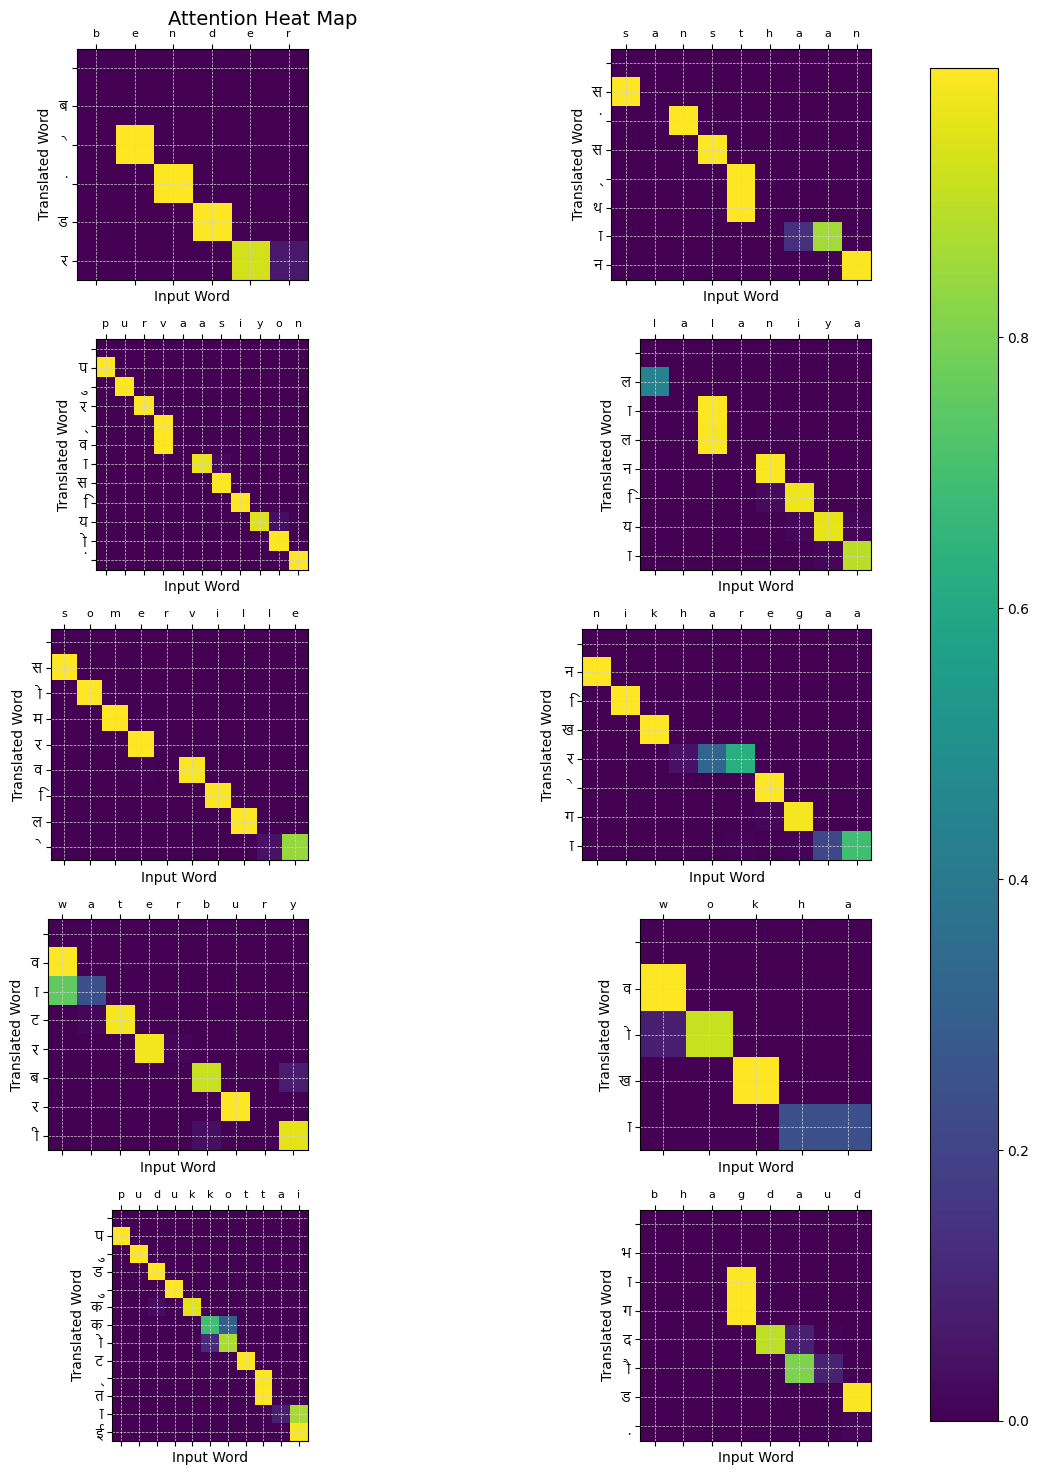

In [99]:
translation_dict, attention_dict = random_test_words(processed_data, model, HYPER_PARAM, device)
plot_attention_grid(translation_dict, attention_dict)